# S9: Baselines Evaluation

Este notebook avalia o modelo baseline para recomendação musicais cold-start, com as seguintes características:
- 51 features: Usa todas as features do GraphSAGE (mesmas features)
- Usa cosine similarity para recomendação e é comparado com o GraphSAGE.

In [1]:
import pandas as pd
import numpy as np
import yaml
import gc
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================================================================
# 1. CONFIGURAÇÃO
# ==============================================================================

BASE_DIR = Path("/Users/lucasborges/Downloads/TCC")
CONFIG_PATH = BASE_DIR / "conf/config.yaml"
with open(CONFIG_PATH, "r") as f:
    config = yaml.safe_load(f)

P = {k: BASE_DIR / v for k, v in config['paths'].items()}
F = config['files']
PM = config['params']

# Parâmetros
K_VALUES = PM['recall_k_values']  # [10, 20, 50, 100]
BATCH_SIZE = 1000
SEED = PM['seed']
CUTOFF_YEAR = 2015

# Configurações visuais
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 300

print(f"✓ Configuração carregada de: {CONFIG_PATH}")
print(f"  K_VALUES = {K_VALUES}")
print(f"  BATCH_SIZE = {BATCH_SIZE}")

✓ Configuração carregada de: /Users/lucasborges/Downloads/TCC/conf/config.yaml
  K_VALUES = [10, 20, 50, 100]
  BATCH_SIZE = 1000


## 2. Definição de Features por Baseline

In [2]:
# Audio Features do Spotify (10 features)
AUDIO_FEATURES = [
    'acousticness', 'danceability', 'energy', 'instrumentalness', 
    'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'duration_ms'
]

# Temporal Context Features (2 features)
TEMPORAL_FEATURES = [
    'ctx_release_year', 'ctx_days_since_release'
]

# Popularity Features (1 feature)
POPULARITY_FEATURES = [
    'artist_followers'
] 

# Key Encoding (2)
KEY_FEATURES = ['key_sin', 'key_cos']

# Mode (1)
MODE_FEATURES = ['mode']

# Album Type (3)
ALBUM_FEATURES = [
    'album_type_1', 'album_type_2', 'album_type_3'
]

# Genre Embeddings (32)
GENRE_FEATURES = [f'genre_emb_{i:02d}' for i in range(32)]

# Baseline: 
BASELINE_FAIR_FEATURES = (
    AUDIO_FEATURES + TEMPORAL_FEATURES + POPULARITY_FEATURES + 
    KEY_FEATURES + MODE_FEATURES + ALBUM_FEATURES + GENRE_FEATURES
)

print("=" * 70)
print("DEFINIÇÃO DE FEATURES POR BASELINE")
print("=" * 70)
print(f"\nBaseline: {len(BASELINE_FAIR_FEATURES)} features")
print(f"\nVerificação: {len(AUDIO_FEATURES) + len(TEMPORAL_FEATURES) + len(POPULARITY_FEATURES) + len(KEY_FEATURES) + len(MODE_FEATURES) + len(ALBUM_FEATURES) + len(GENRE_FEATURES)} features totais")

DEFINIÇÃO DE FEATURES POR BASELINE

Baseline: 51 features

Verificação: 51 features totais


## 3. Funções Auxiliares

In [3]:
def load_features(path, feature_cols):
    """
    Carrega features de arquivo parquet.
    NOTA: Os features já estão normalizados (StandardScaler, RobustScaler)
    """
    df = pd.read_parquet(path)
    
    # Garantir coluna track_uri existe
    if 'track_uri' not in df.columns and 'id' in df.columns:
        df = df.rename(columns={'id': 'track_uri'})
    
    # Carregar features especificadas
    X = df[feature_cols].fillna(0).to_numpy().astype('float32')
    uris = df['track_uri'].to_numpy()
    
    return X, uris

def apply_l2_normalization(X):
    """
    Aplica L2 normalization aos vetores de features.
    Necessário para cosine similarity via dot product.
    """
    norms = np.linalg.norm(X, axis=1, keepdims=True) + 1e-10
    X_norm = X / norms
    return X_norm

def prepare_playlists(tracks_path, cutoff_year, train_uri_set, new_uri_set):
    """
    Prepara playlists para avaliação temporal (mesma lógica do S7).
    """
    df = pd.read_parquet(tracks_path)
    df['release_year'] = pd.to_numeric(df['release_year'], errors='coerce').fillna(0)
    
    # Histórico (treino): release_year <= cutoff
    mask_hist = (df['release_year'] <= cutoff_year) & (df['track_uri'].isin(train_uri_set))
    # Target (teste): release_year > cutoff
    mask_target = (df['release_year'] > cutoff_year) & (df['track_uri'].isin(new_uri_set))
    
    df_hist = df[mask_hist][['pid', 'track_uri']]
    df_target = df[mask_target][['pid', 'track_uri']]
    
    # Agregar por playlist
    hist_dict = df_hist.groupby('pid')['track_uri'].apply(list).to_dict()
    target_dict = df_target.groupby('pid')['track_uri'].apply(set).to_dict()
    
    return hist_dict, target_dict

print("✓ Funções auxiliares definidas")

✓ Funções auxiliares definidas


## 4. Classes de Avaliação

In [4]:
def calculate_metrics(row_scores, uris_new, true_items, k_list):
    """
    Calcula Recall@K e NDCG@K.
    """
    metrics = {}
    max_k = max(k_list)
    
    top_k_indices = np.argpartition(-row_scores, max_k)[:max_k]
    top_k_indices = top_k_indices[np.argsort(-row_scores[top_k_indices])]
    rec_uris = uris_new[top_k_indices]
    
    for k in k_list:
        rec_k = rec_uris[:k]
        hits = len(true_items.intersection(rec_k))
        recall = hits / len(true_items) if len(true_items) > 0 else 0.0
        
        dcg = sum(1.0 / np.log2(rank + 2) for rank, uri in enumerate(rec_k) if uri in true_items)
        idcg = sum(1.0 / np.log2(rank + 2) for rank in range(min(len(true_items), k)))
        ndcg = dcg / idcg if idcg > 0 else 0.0
        
        metrics[f"Recall@{k}"] = recall
        metrics[f"NDCG@{k}"] = ndcg
    
    return metrics

class RecommenderEvaluator:
    """
    Classe para avaliação de recomendadores via cosine similarity.
    """
    def __init__(self, Z_train, train_map, Z_new, uris_new):
        self.Z_train = Z_train
        self.train_map = train_map
        self.Z_new = Z_new
        self.uris_new = uris_new
        
    def get_playlist_embedding(self, tracks_uris):
        """
        Calcula embedding da playlist (média dos embeddings das músicas).
        """
        indices = [self.train_map[u] for u in tracks_uris if u in self.train_map]
        if not indices:
            return None
        vectors = self.Z_train[indices]
        p_vec = np.mean(vectors, axis=0)
        norm = np.linalg.norm(p_vec) + 1e-10
        return p_vec / norm
    
    def compute_metrics_batch(self, pids_list, hist_dict, target_dict, k_list):
        """
        Computa métricas Recall@K e NDCG@K para um batch de playlists.
        """
        p_matrix = []
        valid_batch_pids = []
        
        for pid in pids_list:
            p_vec = self.get_playlist_embedding(hist_dict[pid])
            if p_vec is not None:
                p_matrix.append(p_vec)
                valid_batch_pids.append(pid)
        
        if not p_matrix:
            return []
        
        P = np.array(p_matrix)
        scores = P @ self.Z_new.T  # Dot product = cosine similarity (ambos L2-normalizados)
        
        results = []
        for i, pid in enumerate(valid_batch_pids):
            metrics = calculate_metrics(scores[i], self.uris_new, target_dict[pid], k_list)
            results.append(metrics)
        
        return results

print("✓ Classes de avaliação definidas")

✓ Classes de avaliação definidas


## 5. Carregamento de Dados

In [5]:
print("=" * 70)
print("5. CARREGAMENTO DE DADOS")
print("=" * 70)

# 5.1 Carregar Features
print("\nCarregando features de treino e teste...")
X_TRAIN_PATH = P['processed'] / F['train_features']
X_TEST_PATH = P['processed'] / F['test_features']
TRACKS_COMPLETE_PATH = P['interim'] / 'df_tracks_complete_v5.parquet'

# Carregar todas as features (para reutilizar em múltiplos baselines)
df_train_full = pd.read_parquet(X_TRAIN_PATH)
df_test_full = pd.read_parquet(X_TEST_PATH)

print(f"X_train: {df_train_full.shape}")
print(f"X_test: {df_test_full.shape}")

# Extrair URIs para criar conjuntos de treino e teste
train_uri_set = set(df_train_full['track_uri'].values)
test_uri_set = set(df_test_full['track_uri'].values)

print(f"Train tracks únicos: {len(train_uri_set)}")
print(f"Test tracks únicos: {len(test_uri_set)}")

# 5.2 Carregar Playlists
print("\nCarregando playlists para avaliação temporal...")
hist_by_pid, target_by_pid = prepare_playlists(
    TRACKS_COMPLETE_PATH, CUTOFF_YEAR, train_uri_set, test_uri_set
)

# Filtrar playlists válidas
valid_pids = [
    pid for pid in hist_by_pid 
    if pid in target_by_pid 
    and len(hist_by_pid[pid]) >= 5   # Mínimo 5 tracks no histórico
    and len(target_by_pid[pid]) >= 1  # Mínimo 1 track no target
]

print(f"Playlists válidas: {len(valid_pids):,}")
print(f"  - Média tracks no histórico: {np.mean([len(hist_by_pid[pid]) for pid in valid_pids]):.2f}")
print(f"  - Média tracks no target: {np.mean([len(target_by_pid[pid]) for pid in valid_pids]):.2f}")

5. CARREGAMENTO DE DADOS

Carregando features de treino e teste...
X_train: (324305, 52)
X_test: (60417, 52)
Train tracks únicos: 324305
Test tracks únicos: 60417

Carregando playlists para avaliação temporal...
Playlists válidas: 53,214
  - Média tracks no histórico: 32.48
  - Média tracks no target: 13.73


## 6. Preparação das Features para Cada Baseline

In [6]:
print("\n" + "=" * 70)
print("6. PREPARAÇÃO DAS FEATURES (BASELINE)")
print("=" * 70)

# Baseline (52 features)
print("\n--- Baseline ---")
X_fair_train_raw, uris_train_fair = load_features(X_TRAIN_PATH, BASELINE_FAIR_FEATURES)
X_fair_test_raw, uris_test_fair = load_features(X_TEST_PATH, BASELINE_FAIR_FEATURES)

print(f"Features: {len(BASELINE_FAIR_FEATURES)}")
print(f"X_train shape: {X_fair_train_raw.shape}")
print(f"X_test shape: {X_fair_test_raw.shape}")

# Aplicar L2 normalization (necessário para cosine similarity)
X_fair_train = apply_l2_normalization(X_fair_train_raw)
X_fair_test = apply_l2_normalization(X_fair_test_raw)

print(f"L2 norm médio (train): {np.linalg.norm(X_fair_train, axis=1).mean():.4f}")
print(f"L2 norm médio (test): {np.linalg.norm(X_fair_test, axis=1).mean():.4f}")

# Criar mapeamento URI → índice para treino
train_map_fair = {u: i for i, u in enumerate(uris_train_fair)}

# Liberar memória
del X_fair_train_raw, X_fair_test_raw
del df_train_full, df_test_full
gc.collect()

print("\n✓ Features preparadas")


6. PREPARAÇÃO DAS FEATURES (BASELINE)

--- Baseline ---
Features: 51
X_train shape: (324305, 51)
X_test shape: (60417, 51)
L2 norm médio (train): 1.0000
L2 norm médio (test): 1.0000

✓ Features preparadas


## 7. Avaliação dos Baselines

In [7]:
print("\n" + "=" * 70)
print("7. AVALIAÇÃO DO BASELINE")
print("=" * 70)

# 7.1 Criar Avaliador
print("\nCriando avaliador...")
evaluator_fair = RecommenderEvaluator(X_fair_train, train_map_fair, X_fair_test, uris_test_fair)

print("✓ Avaliador criado")

# 7.2 Avaliar Baseline Justo
print("\n--- Avaliando Baseline ---")
metrics_fair = []
for i in tqdm(range(0, len(valid_pids), BATCH_SIZE), desc="Baseline"):
    batch_pids = valid_pids[i : i + BATCH_SIZE]
    batch_res = evaluator_fair.compute_metrics_batch(batch_pids, hist_by_pid, target_by_pid, K_VALUES)
    metrics_fair.extend(batch_res)

df_fair = pd.DataFrame(metrics_fair)
print(f"Playlists avaliadas: {len(df_fair)}")

# Resumo do baseline
print("\n" + "=" * 70)
print("RESUMO DO BASELINE")
print("=" * 70)
summary = pd.DataFrame({
    'Features': ['Baseline'],
    'Playlists Avaliadas': [len(df_fair)],
    'Recall@10': [df_fair['Recall@10'].mean()],
    'Recall@20': [df_fair['Recall@20'].mean()],
    'Recall@50': [df_fair['Recall@50'].mean()],
    'Recall@100': [df_fair['Recall@100'].mean()],
    'NDCG@10': [df_fair['NDCG@10'].mean()],
    'NDCG@20': [df_fair['NDCG@20'].mean()],
    'NDCG@50': [df_fair['NDCG@50'].mean()],
    'NDCG@100': [df_fair['NDCG@100'].mean()],
})
print(summary)


7. AVALIAÇÃO DO BASELINE

Criando avaliador...
✓ Avaliador criado

--- Avaliando Baseline ---


Baseline: 100%|██████████| 54/54 [00:40<00:00,  1.32it/s]

Playlists avaliadas: 53214

RESUMO DO BASELINE
   Features  Playlists Avaliadas  Recall@10  Recall@20  Recall@50  Recall@100  \
0  Baseline                53214   0.007337   0.012968   0.025439    0.040553   

    NDCG@10   NDCG@20   NDCG@50  NDCG@100  
0  0.009971  0.011322  0.015139  0.020007  


## 8. Carregamento de Métricas do GraphSAGE

In [8]:
print("\n" + "=" * 70)
print("8. CARREGAMENTO DE MÉTRICAS DO GRAPHSAGE")
print("=" * 70)

# Carregar métricas do GraphSAGE v5
GNN_METRICS_PATH = P['metrics'] / 'cold_start_metrics_per_playlist.parquet'
df_gnn = pd.read_parquet(GNN_METRICS_PATH)

print(f"Playlists avaliadas (GraphSAGE): {len(df_gnn)}")

# Resumo do GraphSAGE
df_gnn_summary = pd.DataFrame({
    'Features': ['GraphSAGE'],
    'Playlists Avaliadas': [len(df_gnn)],
    'Recall@10': [df_gnn['Recall@10'].mean()],
    'Recall@20': [df_gnn['Recall@20'].mean()],
    'Recall@50': [df_gnn['Recall@50'].mean()],
    'Recall@100': [df_gnn['Recall@100'].mean()],
    'NDCG@10': [df_gnn['NDCG@10'].mean()],
    'NDCG@20': [df_gnn['NDCG@20'].mean()],
    'NDCG@50': [df_gnn['NDCG@50'].mean()],
    'NDCG@100': [df_gnn['NDCG@100'].mean()],
})

# Combinar resultados
df_final = pd.concat([summary, df_gnn_summary], ignore_index=True)

# Calcular Uplift relativo ao Baseline Justo
baseline_recall = df_final.loc[0, 'Recall@100']
gnn_recall = df_final.loc[1, 'Recall@100']
uplift = (gnn_recall - baseline_recall) / baseline_recall * 100

print("\n" + "=" * 70)
print("RESUMO COMPLETO (INCLUINDO GRAPHSAGE)")
print("=" * 70)
print(df_final)

print(f"\nUplift do GraphSAGE sobre Baseline (Recall@100): +{uplift:.2f}%")


8. CARREGAMENTO DE MÉTRICAS DO GRAPHSAGE
Playlists avaliadas (GraphSAGE): 53179

RESUMO COMPLETO (INCLUINDO GRAPHSAGE)
    Features  Playlists Avaliadas  Recall@10  Recall@20  Recall@50  \
0   Baseline                53214   0.007337   0.012968   0.025439   
1  GraphSAGE                53179   0.005794   0.011224   0.025005   

   Recall@100   NDCG@10   NDCG@20   NDCG@50  NDCG@100  
0    0.040553  0.009971  0.011322  0.015139  0.020007  
1    0.043677  0.006978  0.008589  0.012873  0.018423  

Uplift do GraphSAGE sobre Baseline (Recall@100): +7.71%


In [9]:
# ==============================================================================
# 9. SALVAR MÉTRICAS DE COMPARAÇÃO
# ==============================================================================

# Preparar DataFrame para visualização
recall_metrics = ['Recall@10', 'Recall@20', 'Recall@50', 'Recall@100']
ndcg_metrics = ['NDCG@10', 'NDCG@20', 'NDCG@50', 'NDCG@100']
all_metrics = recall_metrics + ndcg_metrics

vals_baseline = [df_final.loc[0, m] for m in all_metrics]
vals_graphsage = [df_final.loc[1, m] for m in all_metrics]

df_comp = pd.DataFrame({
    'Métrica': all_metrics * 2,
    'Modelo': ['Baseline'] * 8 + ['GraphSAGE'] * 8,
    'Valor': vals_baseline + vals_graphsage
})

# Salvar para uso futuro
comparison_path = P['metrics'] / "comparison_metrics.parquet"
df_comp.to_parquet(comparison_path, index=False)
print(f"✓ Métricas de comparação salvas em: {comparison_path}")

✓ Métricas de comparação salvas em: /Users/lucasborges/Downloads/TCC/reports/metrics/comparison_metrics.parquet


Gerando Figura: Comparação GraphSAGE vs Baseline...
   ✓ Salvo: /Users/lucasborges/Downloads/TCC/reports/figures/comparison_recall.png


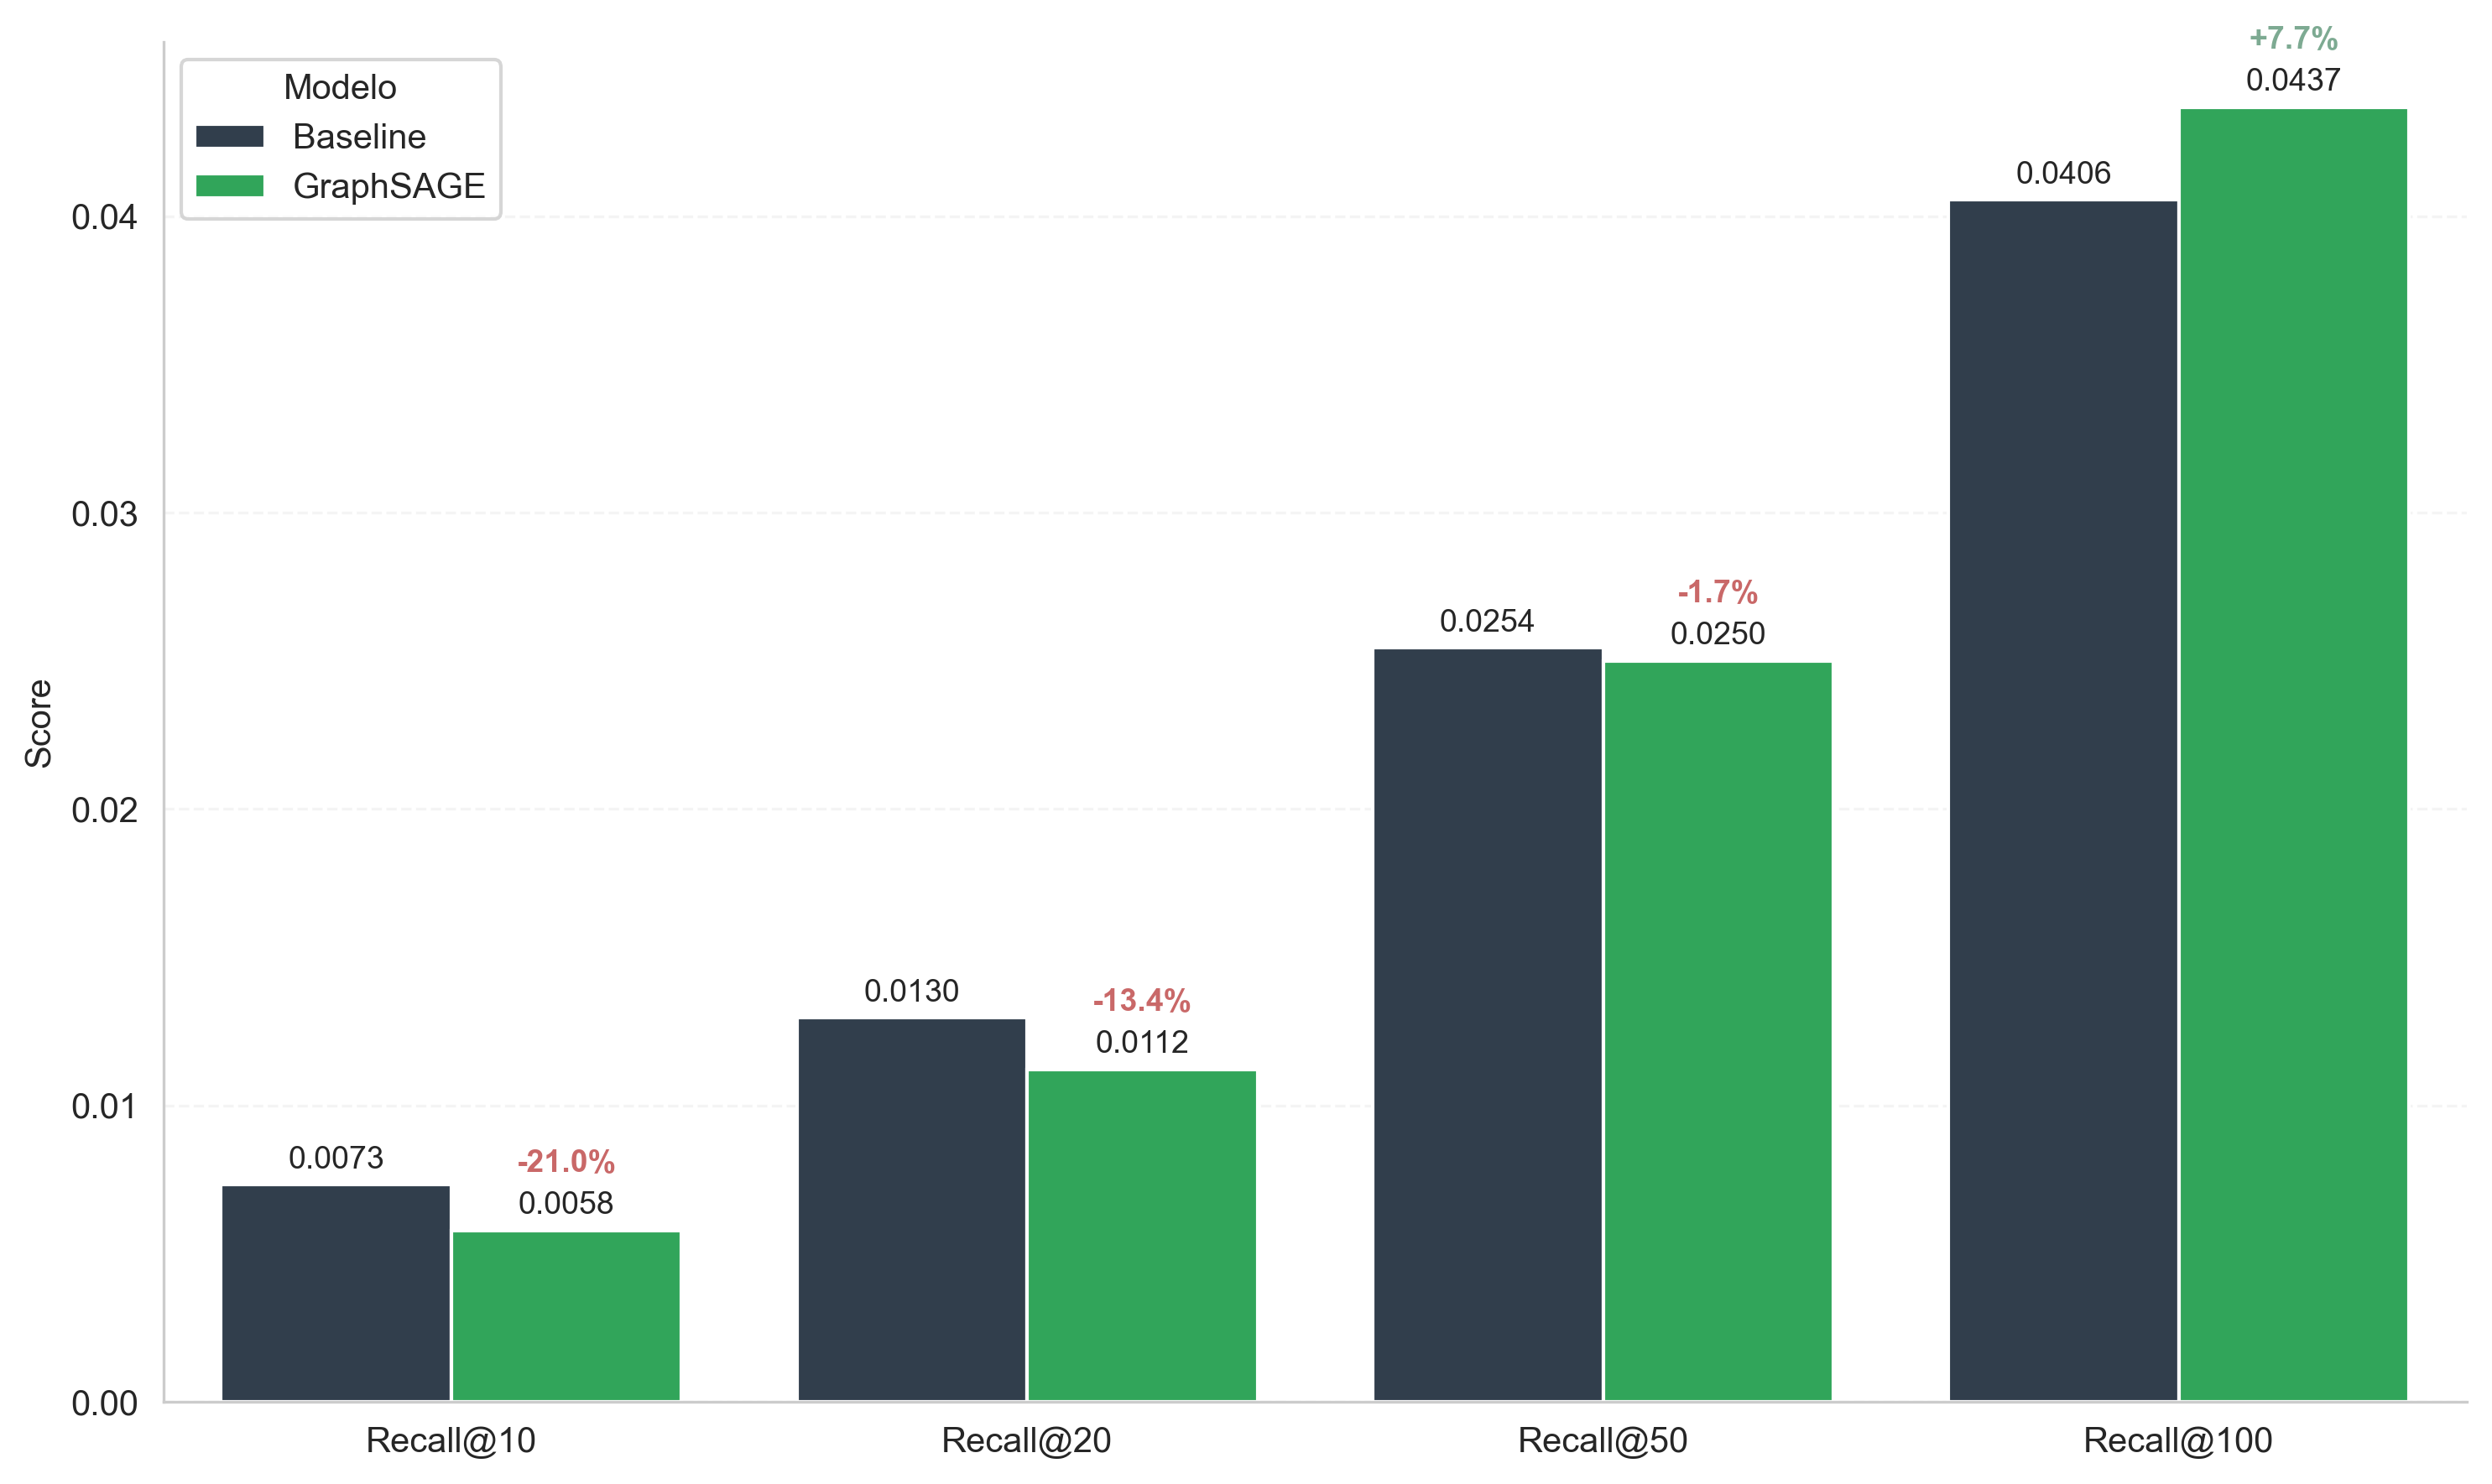

   ✓ Salvo: /Users/lucasborges/Downloads/TCC/reports/figures/comparison_ndcg.png


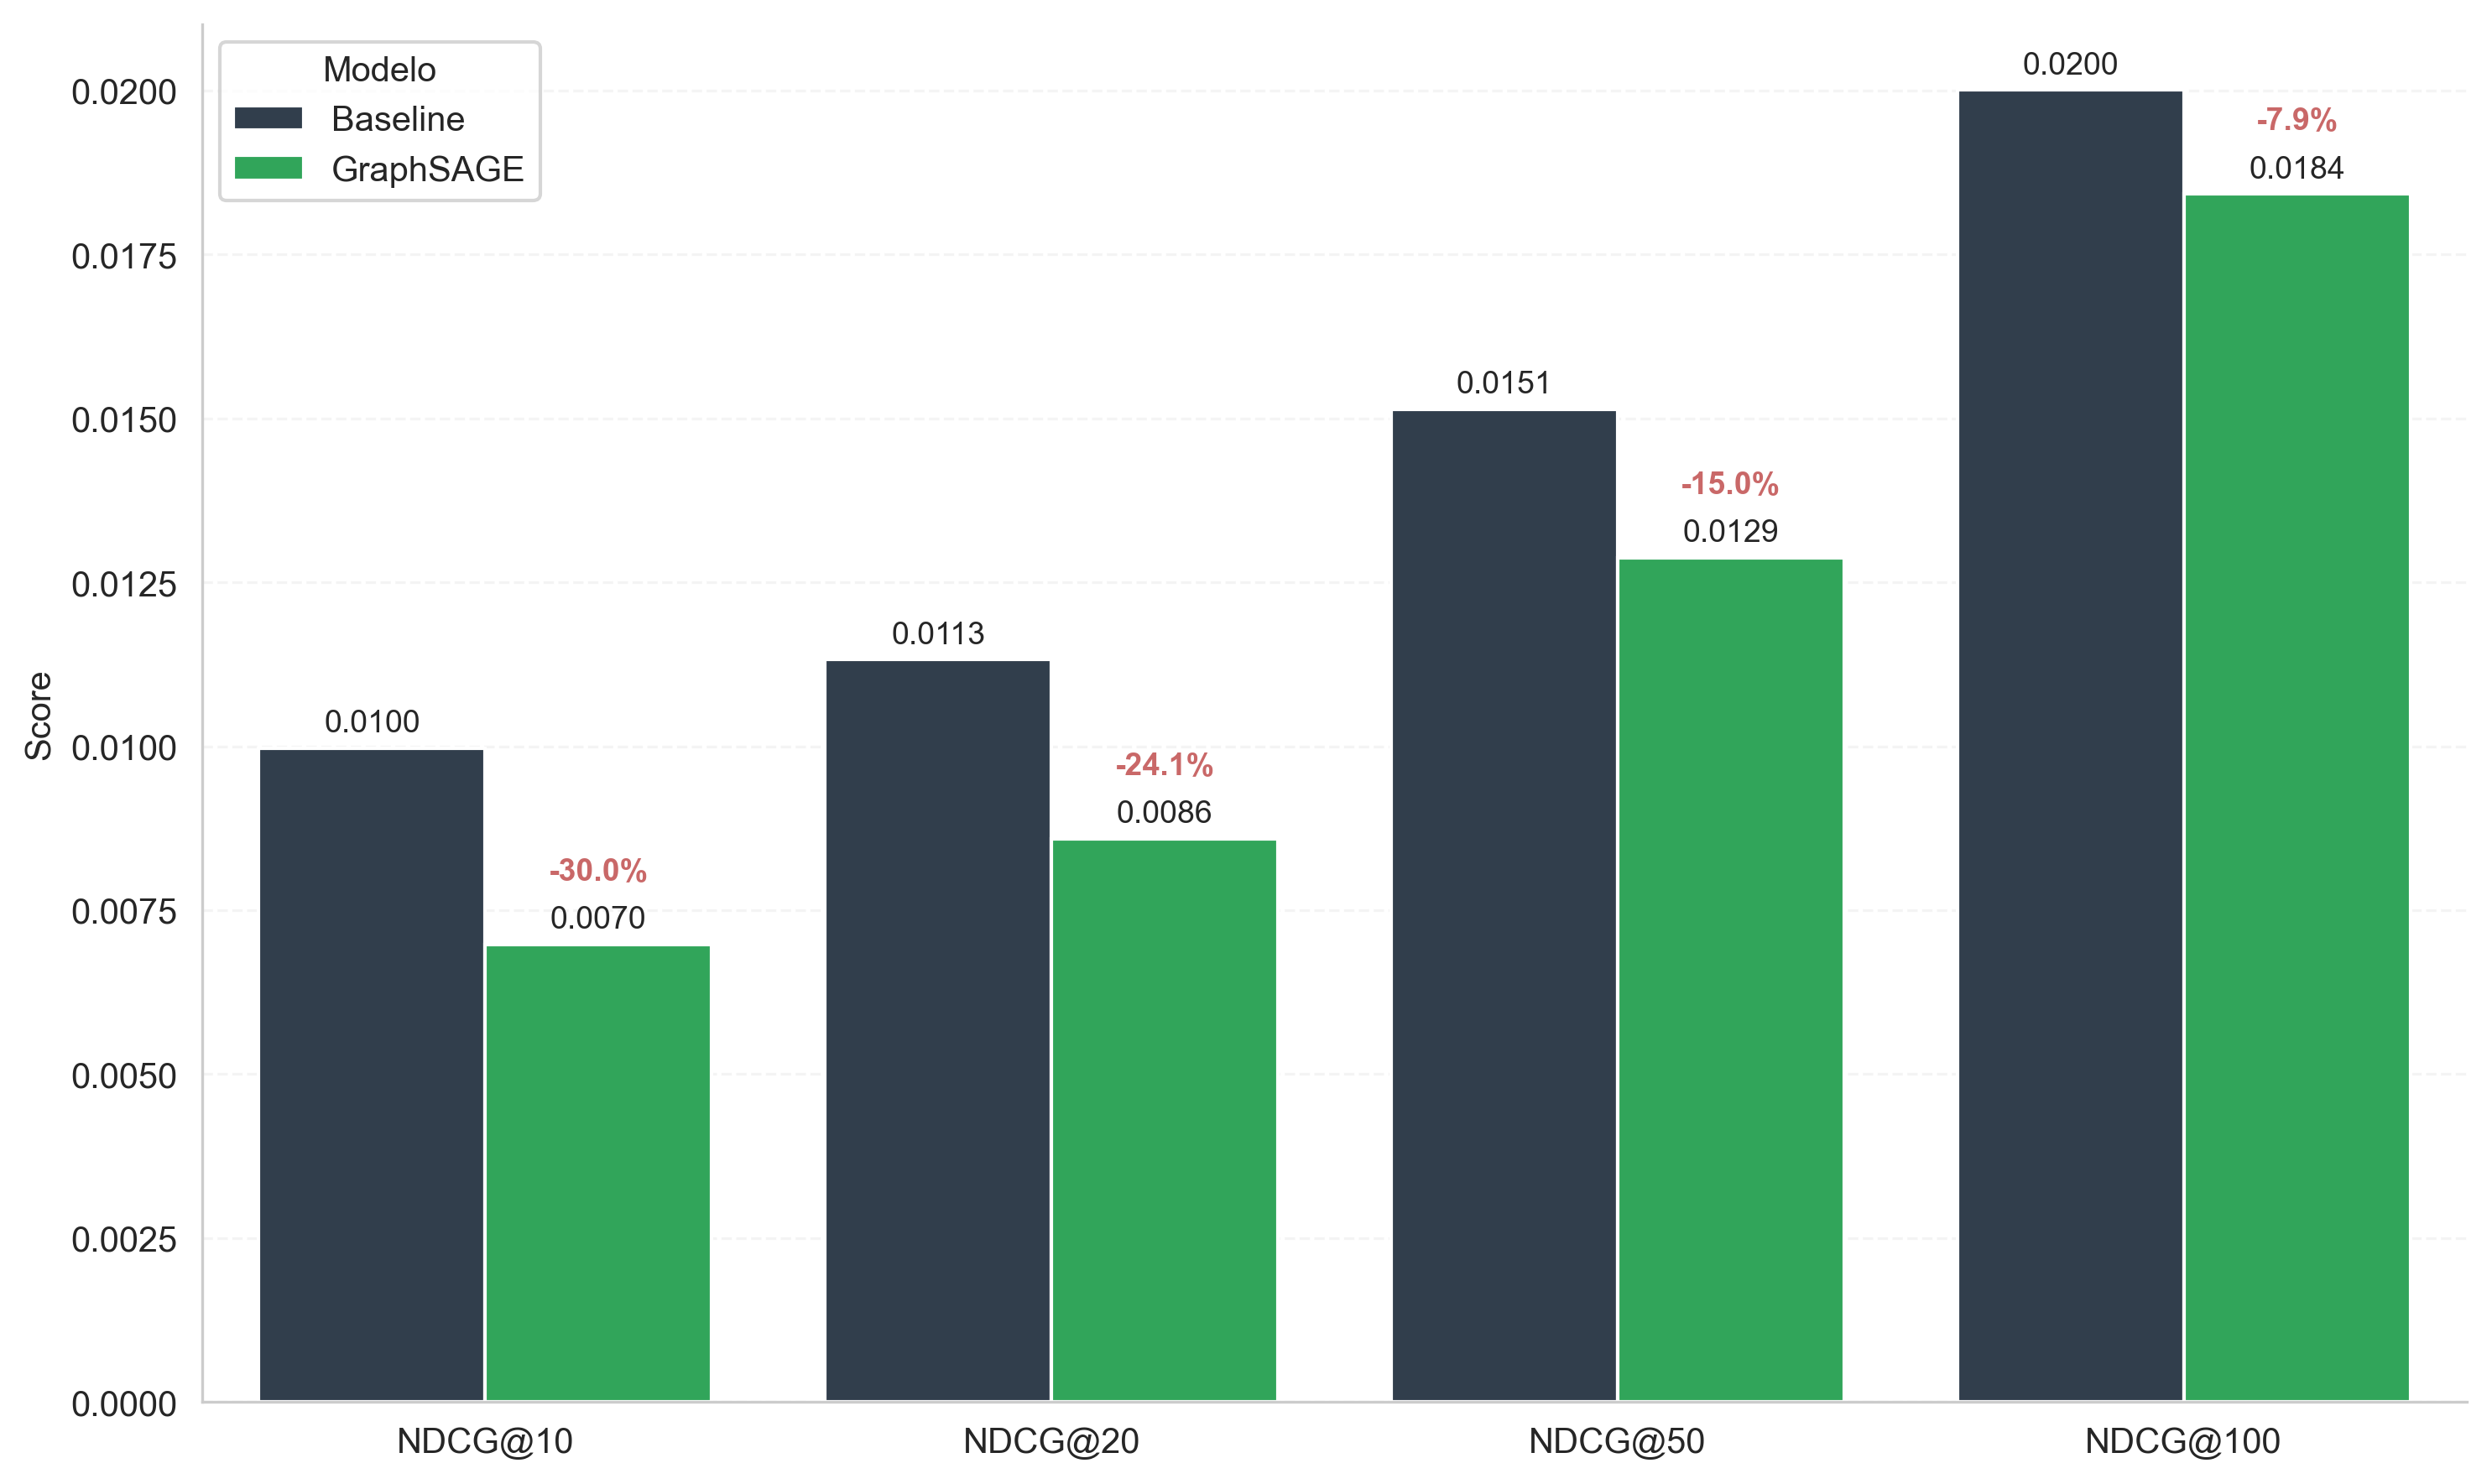

In [10]:
# ==============================================================================
# VISUALIZAÇÃO: Comparação GraphSAGE vs Baseline
# ==============================================================================

# Cores para visualização
C_PRIMARY = "#1DB954"
C_NEUTRAL = "#2C3E50"
C_ACCENT = "#7DAA92"
C_HIGHLIGHT = "#C96868"

def plot_comparison():
    """
    Gera gráficos de comparação entre GraphSAGE e Baseline.
    Carrega dados automaticamente de comparison_metrics.parquet
    """
    print("Gerando Figura: Comparação GraphSAGE vs Baseline...")
    
    comparison_path = P['metrics'] / "comparison_metrics.parquet"
    
    if comparison_path.exists():
        df_comp = pd.read_parquet(comparison_path)
    else:
        # Usar dados já calculados neste notebook
        recall_metrics = ['Recall@10', 'Recall@20', 'Recall@50', 'Recall@100']
        ndcg_metrics = ['NDCG@10', 'NDCG@20', 'NDCG@50', 'NDCG@100']
        all_metrics = recall_metrics + ndcg_metrics
        
        vals_baseline = [df_final.loc[0, m] for m in all_metrics]
        vals_graphsage = [df_final.loc[1, m] for m in all_metrics]
        
        df_comp = pd.DataFrame({
            'Métrica': all_metrics * 2,
            'Modelo': ['Baseline'] * 8 + ['GraphSAGE'] * 8,
            'Valor': vals_baseline + vals_graphsage
        })
        # Salvar para uso futuro
        df_comp.to_parquet(comparison_path, index=False)
        print(f"   ✓ Métricas salvas em: {comparison_path}")
    
    recall_metrics = ['Recall@10', 'Recall@20', 'Recall@50', 'Recall@100']
    ndcg_metrics = ['NDCG@10', 'NDCG@20', 'NDCG@50', 'NDCG@100']
    all_metrics = recall_metrics + ndcg_metrics
    
    # Cálculo de Uplifts
    uplifts = {}
    for metric in all_metrics:
        base_val = df_comp[(df_comp['Métrica'] == metric) & (df_comp['Modelo'] == 'Baseline')]['Valor'].values[0]
        gnn_val = df_comp[(df_comp['Métrica'] == metric) & (df_comp['Modelo'] == 'GraphSAGE')]['Valor'].values[0]
        uplifts[metric] = ((gnn_val - base_val) / base_val) * 100 if base_val != 0 else 0.0

    palette = [C_NEUTRAL, C_PRIMARY]

    # --- GRÁFICO 1: RECALL@K ---
    plt.figure(figsize=(10, 6))
    df_recall = df_comp[df_comp['Métrica'].str.startswith('Recall')]
    
    ax1 = sns.barplot(data=df_recall, x='Métrica', y='Valor', hue='Modelo',
                     palette=palette, edgecolor='white', linewidth=1)
    
    for container in ax1.containers:
        ax1.bar_label(container, fmt='%.4f', padding=3, fontsize=9)
        
    bars_model = ax1.containers[1]
    for i, metric in enumerate(recall_metrics):
        val_model = bars_model[i].get_height()
        uplift = uplifts[metric]
        x_pos = bars_model[i].get_x() + bars_model[i].get_width() / 2
        y_offset = max(val_model * 0.02, 0.002)
        ax1.text(x_pos, val_model + y_offset, f"{uplift:+.1f}%",
                 color=C_ACCENT if uplift > 0 else C_HIGHLIGHT,
                 ha='center', fontweight='bold', fontsize=9)

    ax1.set_ylabel('Score')
    ax1.set_xlabel('')
    sns.despine()
    plt.grid(axis='y', alpha=0.2, linestyle='--')
    plt.tight_layout()
    
    save_path = P['figures'] / "comparison_recall.png"
    save_path.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(save_path, dpi=300, bbox_inches='tight', format='png')
    print(f"   ✓ Salvo: {save_path}")
    plt.show()

    # --- GRÁFICO 2: NDCG@K ---
    plt.figure(figsize=(10, 6))
    df_ndcg = df_comp[df_comp['Métrica'].str.startswith('NDCG')]
    
    ax2 = sns.barplot(data=df_ndcg, x='Métrica', y='Valor', hue='Modelo',
                     palette=palette, edgecolor='white', linewidth=1)
    
    for container in ax2.containers:
        ax2.bar_label(container, fmt='%.4f', padding=3, fontsize=9)
        
    bars_model = ax2.containers[1]
    for i, metric in enumerate(ndcg_metrics):
        val_model = bars_model[i].get_height()
        uplift = uplifts[metric]
        x_pos = bars_model[i].get_x() + bars_model[i].get_width() / 2
        y_offset = max(val_model * 0.02, 0.001)
        ax2.text(x_pos, val_model + y_offset, f"{uplift:+.1f}%",
                 color=C_ACCENT if uplift > 0 else C_HIGHLIGHT,
                 ha='center', fontweight='bold', fontsize=9)
    
    ax2.set_ylabel('Score')
    ax2.set_xlabel('')
    sns.despine()
    plt.grid(axis='y', alpha=0.2, linestyle='--')
    plt.tight_layout()
    
    save_path = P['figures'] / "comparison_ndcg.png"
    plt.savefig(save_path, dpi=300, bbox_inches='tight', format='png')
    print(f"   ✓ Salvo: {save_path}")
    plt.show()

plot_comparison()